# Diagnostics

How to know when your source's PSF info is wrong?  Lookup the right value and compare.

We can lookup the _correct_ psf size values (ie the values at the wavdetect `POS(X,Y)` location)  in the input PSFMAP file and compare them to the values reported by wavdetect.


In [1]:
source /soft/ciao/bin/ciao.bash -o

CIAO configuration is complete... 
CIAO 4.9 Friday, December  2, 2016
  bindir      : /soft/ciao-4.9/bin
  CALDB       : 4.7.3


## combine all the correlation files into a single file

It'll be easiest if we combine all the indivial scale correlation files into a single file.  We can do this with `dmtcalc` and at the same time:

- Add the scale as a column
- Convert logical x_correl and y_correl to physical X,Y

There are better ways to convert the coordinates; but since I know my data are binned by 1, then the conversion from logical to physical is just the X,Y offset, which we can get by dmlist'ing one of the input images:


In [2]:
dmlist acisf02233_broad.psfmap cols

 
--------------------------------------------------------------------------------
Columns for Image Block acisf02233_broad.psfmap
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   acisf02233_broad.psfmap[4006,3168] arcsec       Real4(4006x3168) -Inf:+Inf            
 
--------------------------------------------------------------------------------
Physical Axis Transforms for Image Block acisf02233_broad.psfmap
--------------------------------------------------------------------------------
 
Group# Axis# 
   1   1,2    sky(x) = (+2441.50) +(+1.0)* ((#1)-(+0.50))
                 (y)   (+2677.50)  (+1.0)  ((#2) (+0.50))
 
--------------------------------------------------------------------------------
World Coordinate Axis Transforms for Image Block acisf02233_broad.psfmap
--------------------------------------------------------------------------------
 
Group# Axis# 
   1   1,2    E

In [3]:
dmtcalc 'tmpdir/acisf02233_broad_thresh_000???_??????.fits' \
  all_correlations.dat"[opt kernel=text/simple]" \
  exp="scale=xscales;x=x_correl_max+2441;y=y_correl_max+2677" clob+


> I forced the output to `text/simple` because the `XSCALES` keyword in the correlation files is stored as a string.  `dmtcalc` doesn't have atof (or similar).  Going this route, the simple format looses the datatype, so when I read it back in it then becomes a double (Real8).

### Convert psfmap to logical pixels

The PSFMAP file I created is in units are arcsec.  The values output from wavdetect are in logical pixels.  So we need to convert the pixel values.

Since I binned by 1, the conversion is just the standard `0.492` value.


In [4]:
dmimgcalc "acisf02233_broad.psfmap[1][psfmap]" none logical.psfmap"[psfmap]" op="imgout=((img1/0.492))" clob+

> I rename the output file [psfmap] because the output block name is used as the column name when I run `dmimgpick`.

### Get the PSF size from the psfmap for each correlation location

We can now use `dmimgpick` to select the closest PSF map value to the (X,Y) value in the correlation list


In [5]:
dmimgpick all_correlations.dat logical.psfmap all_corr_with_psf.dat closest clob+

In [6]:
dmlist all_corr_with_psf.dat cols

 
--------------------------------------------------------------------------------
Columns for Table Block all_correlations.dat
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   X_CORREL_MAX                      Real8          -Inf:+Inf            
   2   Y_CORREL_MAX                      Real8          -Inf:+Inf            
   3   CORREL_MAX                        Real8          -Inf:+Inf            
   4   THR_MAX                           Real8          -Inf:+Inf            
   5   SCALE                             Real8          -Inf:+Inf            
   6   X                                 Real8          -Inf:+Inf            
   7   Y                                 Real8          -Inf:+Inf            
   8   psfmap                            Real8          -Inf:+Inf            


### Get PSF size from the psfmap for each source

and now we do the same thing -- getting the PSFMAP value for the X,Y values in the source list

In [7]:
dmimgpick acisf02233_broad.src logical.psfmap srcs_with_psfmap.dat closest clob+

In [8]:
dmlist srcs_with_psfmap.dat cols

 
--------------------------------------------------------------------------------
Columns for Table Block SRCLIST
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   RA                   deg          Real8          0:      360.0        Source Right Ascension
   2   DEC                  deg          Real8          -90.0:       90.0    Source Declination
   3   RA_ERR               deg          Real8          -Inf:+Inf            Source Right Ascension Error
   4   DEC_ERR              deg          Real8          -Inf:+Inf            Source Declination Error
   5   POS(X,Y)             pixel        Real8          2441.50:     6447.50 Physical coordinates
   6   X_ERR                pixel        Real8          -Inf:+Inf            Source X position error
   7   Y_ERR                pixel        Real8          -Inf:+Inf            Source Y position error
   8   NPIXSOU              pixel  

### Compute the diff

The srclist has the `PSF_SIZE` column output from `wavdetect`.  We just added a `PSFMAP` column with the values
picked directly from the psfmap file.  They should be "identical" -- but this would be a boring notebook if they were.

They are different because of the _local_max_ search algorithm.  How different are they?

In [9]:
dmtcalc srcs_with_psfmap.dat srcs_with_psfmap_diff.dat exp="pdiff=((psfmap-psf_size)/psfmap)" clob+

### Plot it
Now we can plot the sources to see which have a large offset between the wavdetect PSF_SIZE
value and the value we get by dmimgpick'ing the PSFMAP value at the wavdetect (X,Y) location.


Gtk-Message: Failed to load module "atk-bridge"


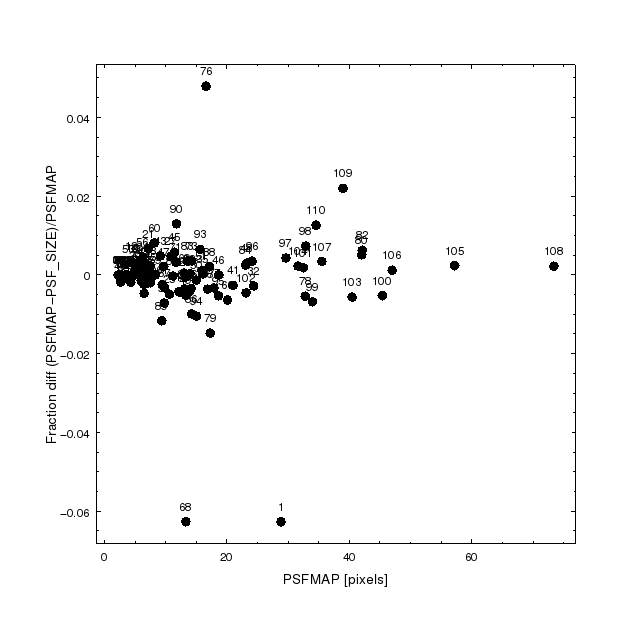

In [10]:
cat << EOM > c1.py
tab=read_file("srcs_with_psfmap_diff.dat")
x = tab.get_column("psfmap").values
y = tab.get_column("pdiff").values
l = tab.get_column("component").values

add_curve(x,y,"line.style=none symbol.style=circle symbol.fill=True")
set_plot_xlabel("PSFMAP [pixels]")
set_plot_ylabel("Fraction diff (PSFMAP-PSF\_SIZE)/PSFMAP")

for a,b,c in zip(x,y,l):
    add_label(a,b,str(c), "halign=0.5 valign=-1")

print_window("diag_chips_01.png","export.clobber=True")
quit()
EOM

chips -n c1.py 
display < diag_chips_01.png

> This figure shows the fractional difference in the PSF_SIZE value reported by wavdetct and the 
> PSFMAP value at the wavdetect (X,Y) [converted to logical pixel size].  As we expect, most the 
> the values are around 0, showing very little difference.  There are some outliers above
> and below 0.02 (ie 2%).  We will take a closer look at these:

In [11]:
dmlist "srcs_with_psfmap_diff.dat[pdiff=:-0.02,0.02:][cols x,y,psfmap,psf_size,component]" data,clean

#  POS(X,Y)                                 psfmap               PSF_SIZE             COMPONENT
      5239.6960784314      3481.6666666667        28.8290531655        30.6370983124          1
      4906.1481481481      4361.3447971781        13.2841676231        14.1166629791         68
      3648.6791443850      4976.8609625668        16.5936520429        15.7986412048         76
      5294.6913580247      3149.3209876543        38.9595070506        38.1034431458        109


> `COMPONENT=68` is the _duplicate_ source we've already looked at.

## `COMPONENT=1`

The basic idea is to now look at the correlation max's and identify which one(s) could have lead to the source.

It's basically a reverse lookup.  The `PSF_SIZE` in the wavdetect output is used to filter the `PSFMAP` values in the all correlation file.  We pick a range of psfmap values near the value we want because they'll never be identical.

In [12]:
dmlist "all_corr_with_psf.dat[psfmap=30.5:30.7]" data,clean

#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX              SCALE                X                    Y                    psfmap
               2863.0                836.0            4.2500230            3.7569570                 1.40               5304.0               3513.0        30.6370994909


So now we know

- From the dmlist above, the correlation max is at 2863,836.
- From the `PSF_SIZE` we know we need to use the wavelet scale equal to `32` files. (Closest in the sqrt(2) sense 30.63)

Using our script from before we can trace this correlation max's path:

In [13]:
python ./pathfinder.py tmpdir/acisf02233_broad_thresh_000320_000320_flux.fits 2863 836 > component_1.reg

In [14]:
wc component_1.reg

  67  402 3350 component_1.reg


> Wow!  That's a long way to go -- about 67 pixels!

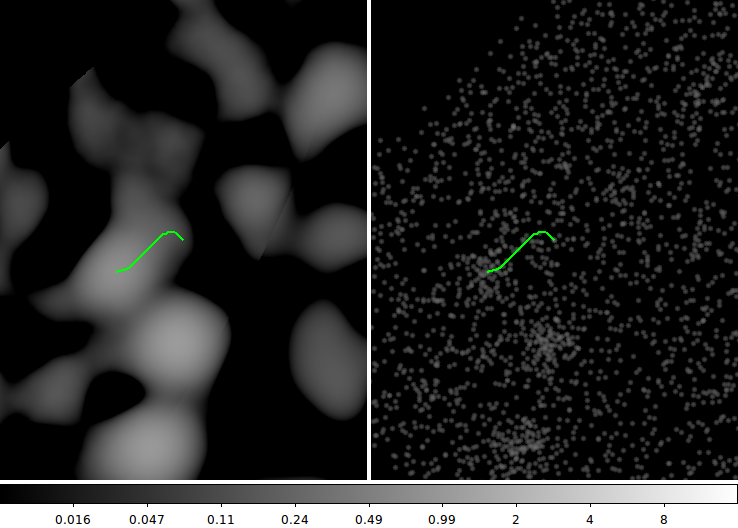

In [15]:
ds9 tmpdir/acisf02233_broad_thresh_000320_000320_flux.fits \
  -scale log -pan to 2863 836 image \
  -region component_1.reg \
  acisf02233_broad_thresh.img \
  -scale log -pan to 2863 836 image -smooth \
  -region component_1.reg \
  -saveimage png diag_ds9_01.png -quit

display < diag_ds9_01.png 

LEFT: Here we see the trace from the low flux values (black) to the high flux values (white).  RIGHT: The same path shown on the broad-band image.

## `COMPONENT=76`


Let's repeat this for the furthest outlier on the other side of the above plot.

In [16]:
dmlist "all_corr_with_psf.dat[psfmap=15.7:15.8]" data,clean

#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX              SCALE                X                    Y                    psfmap
               1222.0               2279.0            24.360170            18.793540                  4.0               3663.0               4956.0        15.7986414142


Okay, so the correlation max was found at sclae=4, but the the PSF size dictates that we use the wavelet scale=16 data.

In [17]:
python ./pathfinder.py tmpdir/acisf02233_broad_thresh_000160_000160_flux.fits 1222 2279 > component_76.reg

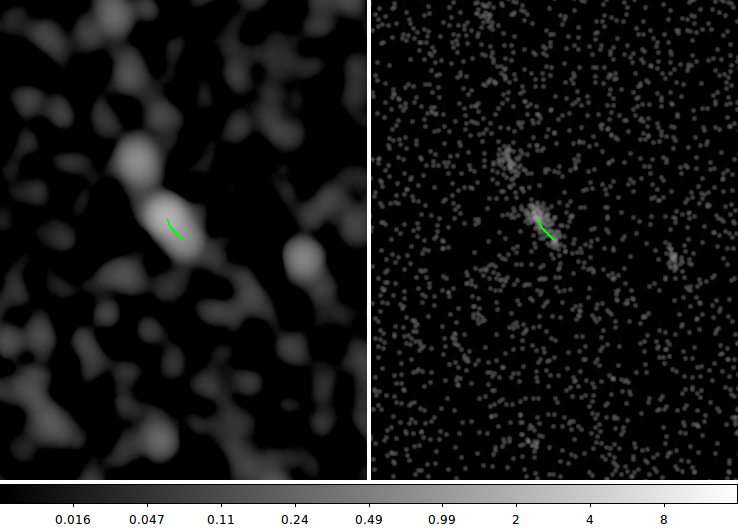

In [18]:
ds9 tmpdir/acisf02233_broad_thresh_000160_000160_flux.fits \
  -scale log -pan to 1222 2279 image \
  -region component_76.reg \
  acisf02233_broad_thresh.img \
  -scale log -pan to 1222 2279 image -smooth \
  -region component_76.reg \
  -saveimage png diag_ds9_76.png -quit

display < diag_ds9_76.png 

> This actually looks like a double source.  The track starts at small Y (bottom) and moves up.  There actually are 
> more correlation max for the brighter source on top, but because the scale=16 image is used (even though the cor max 
> was detected at scale=4, the flux is blurred out enough that the bottom source is absorbed into the top, bright
> source's cell.

> So in this case, the data are _good_ even though we started at the wrong source we extracted the 
> bright source properties.  What we're missing then is the faint source.


## `COMPONENT=109`

In [19]:
dmlist "all_corr_with_psf.dat[psfmap=38.0:38.2]" data,clean

#  X_CORREL_MAX         Y_CORREL_MAX         CORREL_MAX           THR_MAX              SCALE                X                    Y                    psfmap
               2836.0                480.0            47.472820            45.329030                 32.0               5277.0               3157.0        38.1034447895


In [20]:
# Back to using scale=32
python ./pathfinder.py tmpdir/acisf02233_broad_thresh_000320_000320_flux.fits 2836 480 > component_109.reg

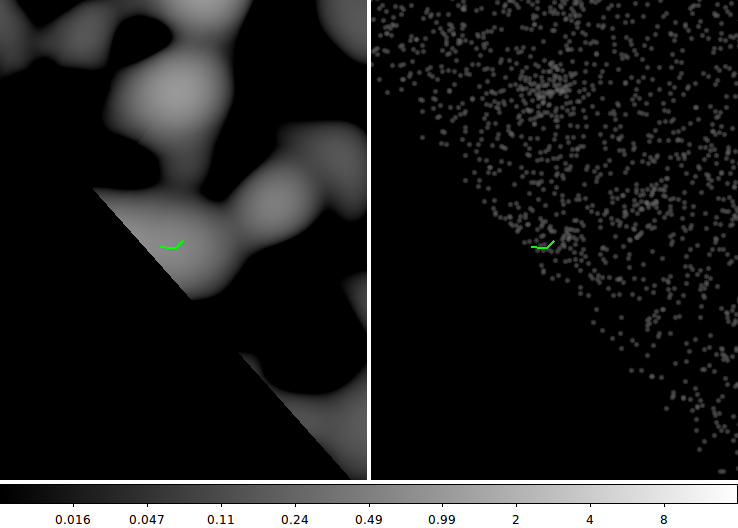

In [21]:
ds9 tmpdir/acisf02233_broad_thresh_000320_000320_flux.fits \
  -scale log -pan to 2836 480 image \
  -region component_109.reg \
  acisf02233_broad_thresh.img \
  -scale log -pan to 2836 480 image -smooth \
  -region component_109.reg \
  -saveimage png diag_ds9_109.png -quit

display < diag_ds9_109.png 

## Summary

This reverse lookup technique isn't robust or really scriptable.  Luckily each of these outliers had only 1 
correlation max with a PSF size near the PSFMAP size.  If there were more then we'd have to filter spatially to find
the nearby ones and then possibly try them all to see which gets us back to the final wavdetect position.